In [1]:
import pandas as pd
import numpy as np
from shapely import geometry
from shapely.ops import cascaded_union
import os, glob

In [63]:
from sklearn.cluster import KMeans

In [218]:
data_folder = r'E:\Data\20240606-4T1noMMt3v210xPE2_colony0529Live3_MF8'

with open(os.path.join(data_folder, 'contours.txt'), 'r') as _f:
    contour_texts = [_l.rstrip() for _l in _f.readlines()]
contours = []
_contour = []
for _l in contour_texts:
    if len(_l.split(',')) == 2:
        _contour.append(np.array(_l.split(','), dtype=np.float32))
    else:
        contours.append(np.array(_contour))
        _contour = []
# final append
contours.append(np.array(_contour))

print(len(contours))

51


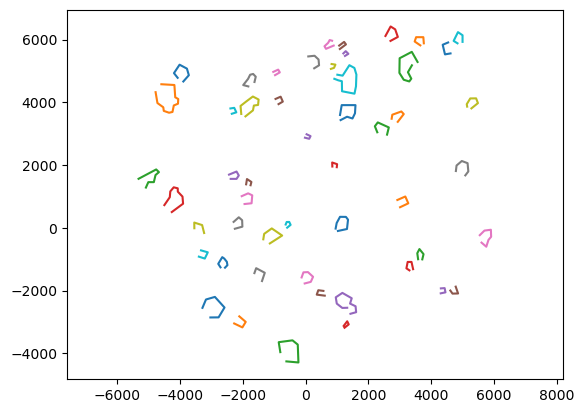

In [219]:
# check moving directions:
import matplotlib.pyplot as plt
plt.figure()
for _ct in contours[:]:
    plt.plot(_ct[:,0], _ct[:,1])
    
plt.axis('equal')
plt.show()

In [221]:
# merged positions for all positions
postions_all = []
grid_size = int(2304 * 0.107 * 0.90) # um
print(grid_size)

for _contour in contours:
    # read contour coords
    points = pd.DataFrame(_contour, columns=['X','Y'])
    # convert to polygon
    tissue = geometry.Polygon(points.values)
    grid_center = np.round(np.array(tissue.centroid.coords)[0], 1)
    grid_inds = [np.arange(np.floor( (np.min(points['X'])-grid_center[0])/grid_size ), 
                  np.ceil( (max(points['X'])-grid_center[0])/grid_size )+1 ),
         np.arange(np.floor( (np.min(points['Y'])-grid_center[1])/grid_size ), 
                  np.ceil( (max(points['Y'])-grid_center[1])/grid_size )+1 ),
        ]
            
    grids = np.array(np.meshgrid(*grid_inds))#.reshape(len(grid_inds),-1).transpose()
    # generate tiles in snake style

    sorted_grids = []
    for _iy in np.arange(grids.shape[-1]):
        _line_grids = grids[:,:,_iy]
        if _iy % 2 == 0:
            sorted_grids.append(_line_grids)
        else:
            sorted_grids.append(np.fliplr(_line_grids))
    
    grids = np.concatenate(sorted_grids, axis=1).transpose()
    
    # get to positions coord inside the grid      
    positions = []

    for _i, _grid in enumerate(grids):
        _grid_position = _grid * grid_size + grid_center
        #print(_grid_position)
        # get each grid point
        _grid_point = geometry.Point(_grid_position)
        _fov_shape = geometry.Polygon([
                _grid_position + [-grid_size/2, -grid_size/2], 
                _grid_position + [grid_size/2, -grid_size/2], 
                _grid_position + [grid_size/2, grid_size/2], 
                _grid_position + [-grid_size/2, grid_size/2], 
            ])
        # calculate intersect
        _intersect = _fov_shape.intersection(tissue)
        if _intersect.area > 0:
            positions.append(_grid_position)
            postions_all.append(_grid_position)
    positions = np.array(positions)
    #print(np.shape(positions))
        
    
postions_all =np.array(postions_all)
merged_save_filename = os.path.join(data_folder, r'positions_all.txt')
exp_date = data_folder.split('\\')[-1].split('-')[0]
analysis_save_filename = os.path.join(data_folder, f'{exp_date}_positions_all.txt')

if os.path.exists(merged_save_filename) and not overwrite:
    print(f"file: {merged_save_filename} already exist, skip!")
else:
    print(f"Save {len(postions_all)} coordinates into the merged file: {merged_save_filename}")
    np.savetxt(merged_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    #np.savetxt(analysis_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    



221
Save 333 coordinates into the merged file: E:\Data\20240606-4T1noMMt3v210xPE2_colony0529Live3_MF8\positions_all.txt


## Plot

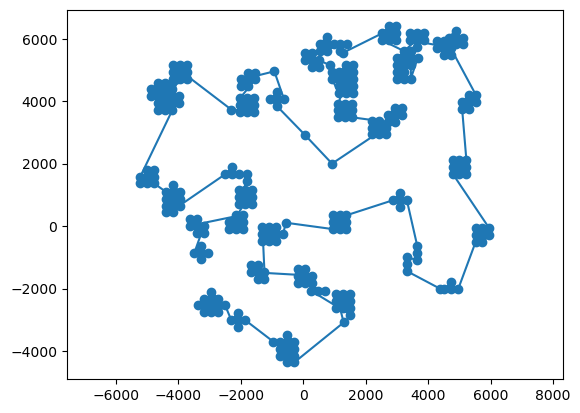

In [217]:
# check moving directions:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(postions_all[:,0],postions_all[:,1], 'o-',)
plt.axis('equal')
plt.show()

# Bad components

In [172]:
from scipy.spatial.distance import pdist, squareform
from scipy.signal import find_peaks

In [173]:
distmap = squareform(pdist(contours))
nearest_dist = np.diag(distmap,1)
relative_dist = 2*nearest_dist[1:-1] - nearest_dist[:-2] - nearest_dist[2:]

In [183]:
relative_dist = nearest_dist[1:] - nearest_dist[:-1]

In [190]:
peaks = find_peaks(relative_dist, width=2, rel_height=3, distance=4, threshold=100)[0] + 1
print(len(peaks))

49


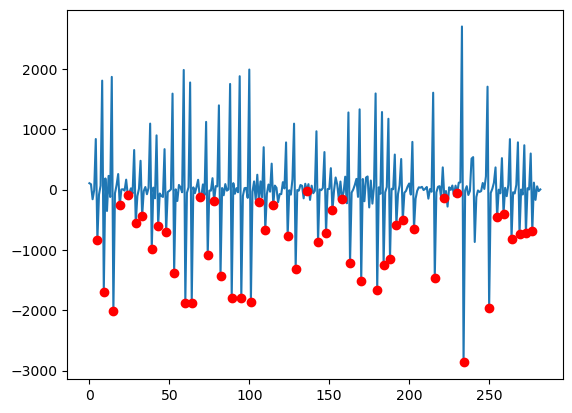

In [191]:
plt.figure()
plt.plot(relative_dist)
plt.plot(peaks, relative_dist[peaks], 'ro')

In [192]:
peaks[:3]

array([ 5,  9, 15], dtype=int64)

In [193]:
splitted_contours = []
heads, tails = [], []
kept_peaks = []
for _ip, _p in enumerate(peaks):
    if _ip > 0:
        head_idx = peaks[_ip-1]+1
    else:
        head_idx = 0
    tail_idx = _p
    # head to tail:
    if len(heads) > 1:
        print(head_idx, tail_idx, distmap[heads[-1], tail_idx])
    splitted_contours.append(contours[head_idx:tail_idx+1])
    
    heads.append(head_idx)
    tails.append(tail_idx)
    

10 15 1730.2171148442617
16 19 2148.4553683286044
20 24 967.2907013406054
25 29 218.003956386117
30 33 607.71879393351
34 39 938.449889978149
40 43 1636.3670784087537
44 48 1330.4688029412791
49 53 785.7896807670612
54 60 1544.562887033092
61 64 2136.485898502492
65 69 1754.0899162813748
70 74 539.7585434247429
75 78 1076.371090284387
79 82 522.3882468049985
83 89 1998.4983821109288
90 95 2423.5961200868433
96 101 2191.882673616451
102 106 2120.8171826208877
107 110 460.44922781996297
111 115 909.9895447751038
116 124 690.6678286991518
125 129 1316.636226335885
130 136 1478.4615696730166
137 143 634.7351435835267
144 148 1044.1015826537187
149 152 570.1634379719555
153 158 973.4146264054184
159 163 161.87994687421914
164 170 1387.7538111999552
171 180 1231.7011113090707
181 184 2333.2286274816706
185 188 1314.7123927688517
189 192 1550.563407926293
193 196 1041.258098888071
197 203 924.6537189672683
204 216 1140.208706684877
217 222 2486.250874107438
223 230 1094.8516208601052
231 234 

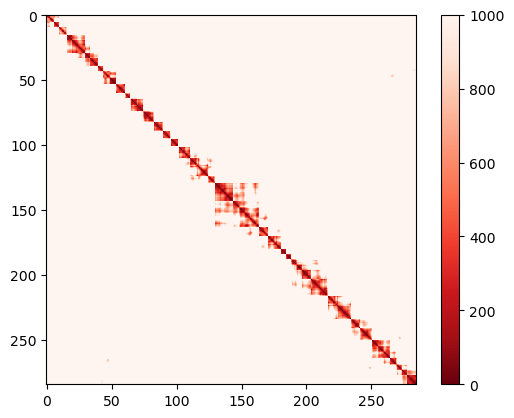

In [194]:
plt.figure()
plt.imshow(distmap, cmap='Reds_r', vmin=0, vmax=1000)
plt.colorbar()

In [207]:
contours[0]

[array(['-3037.72', ' -2856.68'], dtype='<U9'),
 array(['-2776.81', ' -2854.02'], dtype='<U9'),
 array(['-2587.79', ' -2539.87'], dtype='<U9'),
 array(['-2893.96', ' -2201.75'], dtype='<U9'),
 array(['-3178.83', ' -2284.28'], dtype='<U9'),
 array(['-3290.64', ' -2550.52'], dtype='<U9')]